# Ejercicio 1 TP1: Clasificador de noticas.

## Introducción
<div style="text-align:justify">
En este ejercicio se propuso entrenar un modelo que clasifique textos en 20 categorías, provistas por la librería "sklearn". Para importar los datos se usa la función "fetch_20newsgroups" con parámetros train y test, dependiendo del caso. 
</div>

In [6]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np
import matplotlib.pyplot as plt

twenty_train = fetch_20newsgroups(subset='train', shuffle=True, remove = ('headers', 'footers'))
targets_train = twenty_train['target']

twenty_test = fetch_20newsgroups(subset = 'test', remove = ('headers', 'footers'))
targets_test = twenty_test['target']

with open('train_data.txt', 'rt') as file: train_data = file.read().splitlines()
with open('test_data.txt', 'rt') as file: test_data = file.read().splitlines() 
    
#train_data = twenty_train['data']
#test_data = twenty_test['data']

## Implementación
<div style="text-align:justify">
Luego se define la clase "NewsClassifier" cuyo constructor recibe los parámetros correspondientes al "TfidfVectorizer". Esto se implementó para poder tener un modelo dinámico con hiperparámetros fácilmente modificables. Entre éstos se encontrarán: 
</div>

- max_idf: máxima frecuencia entre documentos permitida;
- min_idf: minima frecuencia entre documentos permitida;
- sublinear_tf: suavizado para grandes frecuencias de términos;
- use_idf/smooth_idf: uso de idf y suavizado para evitar divisiones por cero;
- norm: normalización (norma 1 o norma 2).

### Entrenamiento
<div style="text-align:justify">
En primer lugar se le aplica la vertorización "TF-IDF" a los datos de entrenamiento, usando los parámetros pasados en el constructor. Ésto nos dará una matriz esparza con puntajes, y cuyas filas y columnas serán los textos y las palabras, respectivamente. También se guardan las probabilidades a priori de cada una de las clases. 
</div> 
<div style="text-align:justify">
Paralelamente, se define una matriz de probabilidades de dimensión 20xN donde "N" es la cantidad de palabras en el vocabulario. Luego se itera por cada una de las clases. En cada una de estas iteraciones se suman los puntajes de cada una de las palabras en noticias de la clase por la cual se está iterando. Se aplica un factor de smoothing, con el propósito de evitar probabilidades iguales a cero. Finalmente se divide a estos puntajes por la suma de todos para convertirlos en probabilidades, y se guardan estas probabilidades en la fila correspondiente de la matriz de probabilidades. Con este último paso, el modelo queda entrenado y está apto para realizar predicciones.
</div>



### Predicción

<div style="text-align:justify">
    Para predicir, primero se toman los textos a clasificar y se guardan las palabras, según el vocabulario entrenado, en una matriz esparza. En esta matriz, a diferencia del entrenamiento, se guardan las repeticiones de cada una. Con el proposito de utilizar "Naive Bayes", se quiere aplicar la siguiente fórmula:
</div>


<center>
    $P(x_1,x_2,...,x_N|y) = \prod_{i=1}^N P(x_i|y)^{n_{ij}}$
</center>


<div style="text-align:justify">
    Donde $x_i$ es cada una de la palabras del vocabulario y $n_{ij}$ la cantidad de repeticiones de la palabra $x_i$ en el texto "j". Esta probabilidad obtenida será el likelihood naive, asumiendo independencia y approach BOW. Luego, se calcula este likelihood para cada una de las clases "y", y a cada uno se lo multiplica por su probabilidad a priori obtenida durante el entrenamiento. Finalmente se dirá que el texto será de la clase con mayor probabilidad a posteriori, o sea, $P(y|x_1,x_2,...,x_N)$, que será proporcional a $P(x_1,x_2,...,x_N|y)\cdot P(y)$.
</div>

<div style='text-align:justify'>
El único cambio que en este trabajo se le aplicó a la fórmula de Naive Bayes, es el hecho de comparar los logaritmos de P(y|x). Esto se decidió hacer así para evitar tener números muy pequeños debido a los productos de las probabilidades. Por lo tanto, la fórmula de Naive Bayes se reescribe de la siguiente forma:
</div>

<center>
    $\log(P(y|x)) = \sum_{i=1}^N (n_{ij}\cdot \log(P(x_i|y))) + \log(P(y))$
</center>

En la fórmula anterior se puedde ver la necesidad del smoothing ya que, de no haberlo, se estarían evaluando logaritmos en cero.

<div style='text-align:justify'>
Para aplicar esto en nuestro caso particular, se toma a la matriz esparza mencionada, y se la multiplica matricialmente por la matriz de logaritmos de probabilidades, traspuesta. Esto da como resultado una matriz, cuyas columnas serán las distintas clases y sus filas serán los distintos textos a predecir. En los pares fila-columna (i-j) estarán los logaritmos de likelihood del texto "i" para la calse "j". Si a cada columna se le suma el logaritmo de la probabilidad a priori de la clase correspondiente, entonces la matriz se transforma en una matriz de logaritmos a posteriori. Finalmente, el vector de predicciones serán las columnas con probabilidad a posteriori máxima de cada fila.
</div>

In [4]:

class NewsClassifier:
    def __init__(self, **kwargs):
        self.tfidf = TfidfVectorizer(**kwargs, stop_words = 'english')

        
        self.got_hist = False
        
    def fit(self, train_set, targets):
        
        self.got_hist = False
        
        self.train_set = train_set
        self.targets_train = targets

        self.groups = np.unique(targets)
        
        self.fitted_train = self.tfidf.fit_transform(train_set)
        self.priori = np.mean(self.targets_train == self.groups.reshape(-1, 1), axis = 1)
        
        self.probabilities = np.zeros((20, self.fitted_train.shape[1]))
        
        for i, group in enumerate(self.groups):
            row = self.fitted_train[self.targets_train == group].sum(axis = 0)
            row += row[row > 0].min()
            self.probabilities[i] = row / row.sum()
        
        self.cv = CountVectorizer(stop_words = 'english', vocabulary = self.tfidf.get_feature_names())

            
    def df_hist(self, **kwargs):
        if not self.got_hist:
            df = self.fitted_train.getnnz(axis = 0) / self.targets_train.size
        
            self.hist_height, self.hist_x, container = plt.hist(df * 100, bins = int(np.sqrt(df.size)), **kwargs)
            self.hist_width = (self.hist_x[-1] - self.hist_x[0]) / (self.hist_x.size - 1)
            self.hist_x = (self.hist_x[:-1] + self.hist_x[1:])/2
            self.got_hist = True
        else:
            plt.bar(self.hist_x, self.hist_height, width = self.hist_width)
        
        plt.yscale('log')
        plt.xlabel('%')
        plt.ylabel('Cantidad de palabras')
        
            
    def score(self, test_set, targets):
        
        pred_test = self.predict(test_set)
        
        return np.mean(pred_test == targets)
    
    def predict(self, input_data):
        fitted_test = self.cv.transform(input_data)
        probs_test = fitted_test.dot(np.log(self.probabilities).T) + np.log(self.priori)
        pred_test = self.groups[np.argmax(probs_test, axis = 1)]
        
        return pred_test

In [43]:
max_df = np.arange(.01, .26, .05)
smooth_idf = np.array([True, False])
use_idf = np.array([True, False])
sublinear_tf = np.array([True, False])
norm = np.array(['l1', 'l2'])

res = np.zeros((max_df.size, smooth_idf.size, use_idf.size, sublinear_tf.size, norm.size))

for i, df in enumerate(max_df):
    for j, smooth in enumerate(smooth_idf):
        for z, idf in enumerate(use_idf):
            for k, subtf in enumerate(sublinear_tf):
                for l, nrm in enumerate(norm):
                    classifier = NewsClassifier(max_df = df, smooth_idf = smooth, use_idf = idf, sublinear_tf = subtf, norm = nrm)
                    
                    classifier.fit(train_data, targets_train)
                    res[i, j, z, k, l] = classifier.score(test_data, targets_test)
                    
best = res.max()
argmax = np.argwhere(res == best)[0]
print(f'Best max_df: {max_df[argmax[0]]}')
print(f'Best smoothing: {smooth_idf[argmax[1]]}')
print(f'Best use_idf: {use_idf[argmax[2]]}')
print(f'Best subtf: {sublinear_tf[argmax[3]]}')
print(f'Best norm: {norm[argmax[4]]}')
print(f'Best result: {best}')

Best max_df: 0.11
Best smoothing: True
Best use_idf: False
Best subtf: True
Best norm: l2
Best result: 0.8016463090812533


In [44]:
max_df = np.arange(.06, .07, .001)
use_idf = False
sublinear_tf = True

res = np.zeros(max_df.size)

for i, df in enumerate(max_df):
    classifier = NewsClassifier(max_df = df, use_idf = use_idf, sublinear_tf = sublinear_tf)
    classifier.fit(train_data, targets_train)
    res[i] = classifier.score(test_data, targets_test)
        
best = res.max()
argmax = np.argwhere(res == best)[0]
print(f'Best max_df: {max_df[argmax]}')
print(f'Best result: {best}')

Best max_df: [0.063]
Best result: 0.8028412108337759


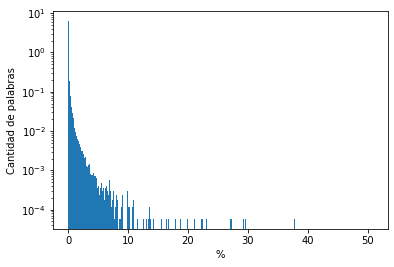

In [45]:
classifier = NewsClassifier(max_df = 1.0)                    
classifier.fit(train_data, targets_train)
classifier.df_hist(density = True)

In [7]:
classifier = NewsClassifier(max_df = .063, sublinear_tf = True, use_idf = False)                    
classifier.fit(train_data, targets_train)
print(classifier.score(test_data, targets_test))

0.8028412108337759


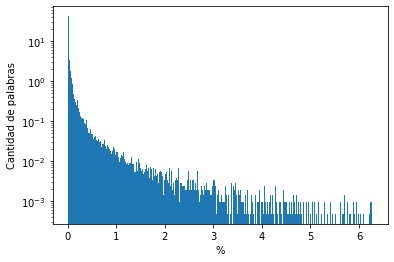

In [47]:
classifier.df_hist(density = True)